# Medical Trial Case Study

## 1) Background Information

XYZ client is currently using Medication A for all their patients and is considering switching to Medication B. An essential aspect of evaluating Medication B is determining the anticipated usage in XYZ's patients. A trial was conducted to assess Medication B's effectiveness, and data for approximately 130 patients has been collected. This data includes information from at least 2 months prior to switching medications and up to 3 months after switching to Medication B.

### Key considerations:

- Patients can be on either Medication A or Medication B, but not both simultaneously.
- Medication B is administered less frequently (~1 time per month) than Medication A.
- The units for Medication A and Medication B are different and cannot be converted between each other.
- Time on Medication A is defined as the period between the first and last recorded administration of Medication A.
- A week is defined as 7 days, and a month is assumed to be 4.33 weeks.

## 2) Metadata of the File

The data file contains the following information:

### **Admin:**

- **ID**: patient ID
- **Med**: Med type
- **Admin Date**: Dates of administration
- **Units**: Dosage units administered for each medication

### **Labs:**

- **ID**: patient ID
- **DRAW_DATE**: draw date
- **LAB_RESULT_CODE**: different types of lab tests
- **LAB_VALUE**: lab values

## 3) Business Goal

The main objective is to evaluate the potential adoption of Medication B by XYZ's patients. Specifically, the goal is to analyze the usage patterns, switching trends, and dosing behavior to make informed decisions regarding the transition from Medication A to Medication B. Additionally, the cost-effectiveness of Medication B compared to Medication A will be assessed.


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


### Load the Data

Let's start by loading the data from the two CSV files: `Admin.csv` and `Labs.csv`.

In [3]:
# Load the Admin data
admin_df = pd.read_csv('Admin.csv')
admin_df.head()

ID    Med  Admin Date     Units
0   1  Med A  02/07/2012  1,500.00
1   1  Med A  06/07/2012  1,500.00
2   1  Med A  09/07/2012  1,500.00
3   1  Med A  11/07/2012  1,500.00
4   1  Med A  13/07/2012  1,500.00

In [4]:
# Load the Labs data
labs_df = pd.read_csv('Labs.csv')
labs_df.head()

ID DRAW_DATE LAB_RESULT_CODE LAB_VALUE
0  1.0    04-Jul           LAB A       679
1  1.0    01-Aug           LAB A       621
2  1.0    05-Sep           LAB A       915
3  1.0    03-Oct           LAB A       848
4  1.0    07-Nov           LAB A       845

### Data Preprocessing

Before diving into analysis, we need to preprocess the data. This includes converting date columns to datetime objects and ensuring numeric columns are indeed numeric.

In [5]:
# Convert date columns to datetime
admin_df['Admin Date'] = pd.to_datetime(admin_df['Admin Date'], errors='coerce')
labs_df['DRAW_DATE'] = pd.to_datetime(labs_df['DRAW_DATE'], errors='coerce')

# Convert LAB_VALUE to numeric
labs_df['LAB_VALUE'] = pd.to_numeric(labs_df['LAB_VALUE'], errors='coerce')

# Convert Units to numeric
admin_df['Units'] = pd.to_numeric(admin_df['Units'], errors='coerce')

### Exploratory Data Analysis (EDA)

Let's start with some basic exploratory data analysis to understand the distribution and relationships within the data.

In [6]:
# Summary statistics for Admin data
admin_df.describe()

ID                     Admin Date       Units
count  2022.000000                            876  375.000000
mean     66.767557  2012-06-20 11:33:41.917808128  256.397333
min       1.000000            2012-01-08 00:00:00    1.000000
25%      32.250000            2012-03-09 00:00:00    4.000000
50%      67.000000            2012-06-08 00:00:00   10.000000
75%     100.000000            2012-10-07 00:00:00  700.000000
max     129.000000            2012-12-10 00:00:00  900.000000
std      37.973341                            NaN  336.385163

In [7]:
# Summary statistics for Labs data
labs_df.describe()

ID DRAW_DATE    LAB_VALUE
count  2095.000000         0  2394.000000
mean     65.557041       NaT   194.355054
min       1.000000       NaT     3.000000
25%      31.000000       NaT    10.700000
50%      66.000000       NaT    13.000000
75%      99.000000       NaT    60.750000
max     129.000000       NaT  3060.000000
std      38.453118       NaN   382.224700

1. Total Monthly Medication Usage: What is the total number of units administered for each medication in each month across all patients?

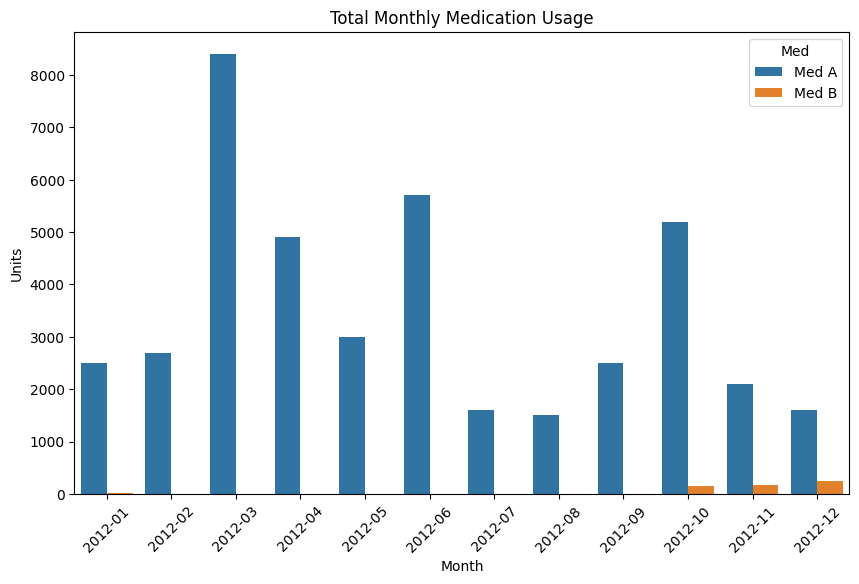

In [16]:
# Total monthly usage for each medication
admin_df['Month'] = admin_df['Admin Date'].dt.to_period('M')  # Convert to monthly period

# Group by medication type and month, and sum the units
monthly_usage = admin_df.groupby(['Med', 'Month'])['Units'].sum().reset_index()

# Plot total units administered per month for each medication
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Units', hue='Med', data=monthly_usage)
plt.title('Total Monthly Medication Usage')
plt.xticks(rotation=45)
plt.show()

2. Patient Counts on Each Medication: How many patients received Medication A and Medication B from July to November?

Med         object
Month    period[M]
ID           int64
dtype: object


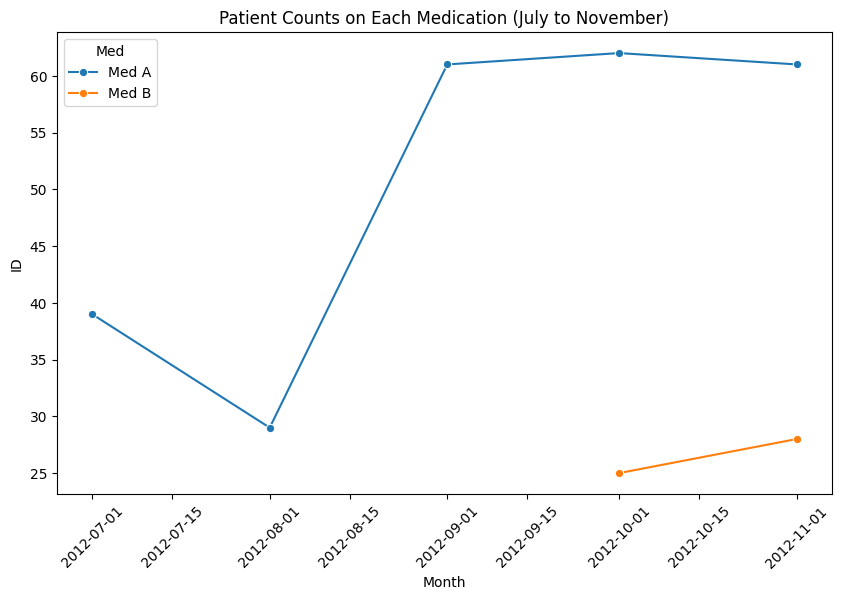

In [19]:
# Check data types
print(patient_counts.dtypes)

# Convert 'Month' to datetime if necessary
if pd.api.types.is_period_dtype(patient_counts['Month']):
    patient_counts['Month'] = patient_counts['Month'].dt.to_timestamp()
elif not pd.api.types.is_datetime64_any_dtype(patient_counts['Month']):
    patient_counts['Month'] = pd.to_datetime(patient_counts['Month'], format='%Y-%m')

# Ensure 'ID' is numeric
patient_counts['ID'] = pd.to_numeric(patient_counts['ID'], errors='coerce')

# Drop any rows with NaN values that may have been introduced
patient_counts.dropna(inplace=True)

# Plot the number of patients per medication each month
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='ID', hue='Med', data=patient_counts, marker='o')
plt.title('Patient Counts on Each Medication (July to November)')
plt.xticks(rotation=45)
plt.show()

3. Average Monthly Dose per Patient: What is the average total monthly dose per patient for each medication from July to November?

ID                     int64
Med                   object
Admin Date    datetime64[ns]
Units                float64
Month         datetime64[ns]
dtype: object


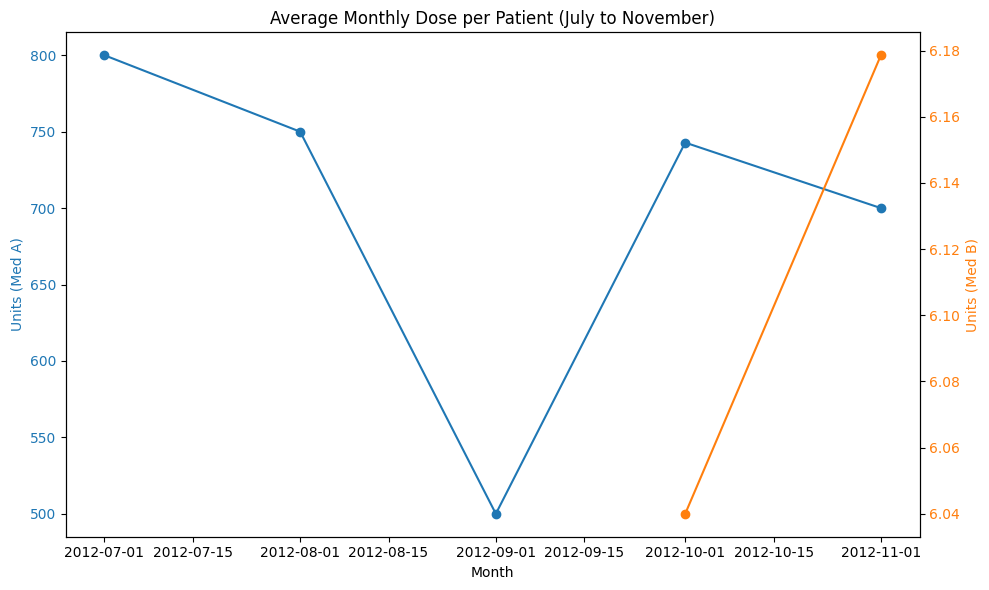

In [21]:
# Check data types
print(filtered_df.dtypes)

# Convert 'Month' to datetime if necessary
if pd.api.types.is_period_dtype(filtered_df['Month']):
    filtered_df['Month'] = filtered_df['Month'].dt.to_timestamp()
elif not pd.api.types.is_datetime64_any_dtype(filtered_df['Month']):
    filtered_df['Month'] = pd.to_datetime(filtered_df['Month'], format='%Y-%m')

# Ensure 'Units' is numeric
filtered_df['Units'] = pd.to_numeric(filtered_df['Units'], errors='coerce')

# Drop any rows with NaN values that may have been introduced
filtered_df.dropna(inplace=True)

# Calculate total dose per patient for each month
monthly_dose = filtered_df.groupby(['ID', 'Med', 'Month'])['Units'].sum().reset_index()

# Calculate average dose per patient per month for each medication
avg_monthly_dose = monthly_dose.groupby(['Med', 'Month'])['Units'].mean().reset_index()

# Plot the average total dose per patient each month for each medication with separate y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

medications = avg_monthly_dose['Med'].unique()
colors = ['tab:blue', 'tab:orange']

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for i, med in enumerate(medications):
    med_data = avg_monthly_dose[avg_monthly_dose['Med'] == med]
    if i == 0:
        ax1.plot(med_data['Month'], med_data['Units'], color=colors[i], marker='o', label=med)
        ax1.set_ylabel(f'Units ({med})', color=colors[i])
        ax1.tick_params(axis='y', labelcolor=colors[i])
    else:
        ax2.plot(med_data['Month'], med_data['Units'], color=colors[i], marker='o', label=med)
        ax2.set_ylabel(f'Units ({med})', color=colors[i])
        ax2.tick_params(axis='y', labelcolor=colors[i])

plt.title('Average Monthly Dose per Patient (July to November)')
ax1.set_xlabel('Month')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(rotation=45)
plt.show()

4. Switching Analysis:
How many patients switched from Medication A to Medication B each month (September, October, November)?
How many patients started on Medication B without being on Medication A in the past?

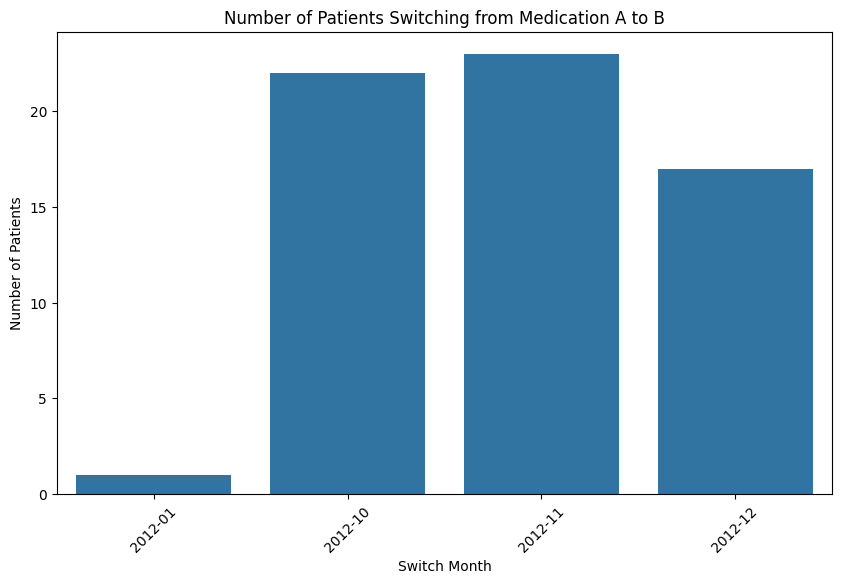

In [30]:
# Convert 'Admin Date' to datetime if necessary
if not pd.api.types.is_datetime64_any_dtype(admin_df['Admin Date']):
    admin_df['Admin Date'] = pd.to_datetime(admin_df['Admin Date'])

# Identify patients who switched from A to B
switch_df = admin_df.pivot_table(index='ID', columns='Med', values='Admin Date', aggfunc='min')

# Patients who switched from A to B
try:
    switch_df = switch_df.dropna(subset=['Med A', 'Med B'])  # Patients with both medications
except KeyError as e:
    print(f"\nKeyError: {e}")
    print("Columns in switch_df:", switch_df.columns)

switch_df['Switch Month'] = switch_df['Med B'].dt.to_period('M')  # Month of switch

# Reset index to make 'ID' a column again
switch_df = switch_df.reset_index()

# Count patients who switched each month
switch_count = switch_df.groupby('Switch Month')['ID'].count().reset_index()

# Plot patients switching from A to B
plt.figure(figsize=(10, 6))
sns.barplot(x='Switch Month', y='ID', data=switch_count)
plt.title('Number of Patients Switching from Medication A to B')
plt.xlabel('Switch Month')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()

In [32]:
# Patients who started on B without being on A
start_on_b_df = admin_df[admin_df['Med'] == 'Med B']
patients_no_A = start_on_b_df[~start_on_b_df['ID'].isin(switch_df['ID'])]['ID'].nunique()

# Number of patients who started on Medication B without being on Medication A
patients_no_A

34

In [35]:
switch_df.head()

Med  ID      Med A      Med B Switch Month  Time on A (Weeks)
0     1 2012-01-08 2012-12-09      2012-12          48.000000
1     4 2012-01-08 2012-12-09      2012-12          48.000000
2     5 2012-01-08 2012-12-09      2012-12          48.000000
3     8 2012-01-09 2012-11-10      2012-11          43.714286
4     9 2012-01-09 2012-11-10      2012-11          43.714286

5. Time on Medication A Before Switch:
For patients who switched to Medication B, what is the average number of weeks spent on Medication A before switching?

In [34]:
# Calculate time on Medication A before switching to B
switch_df['Time on A (Weeks)'] = (switch_df['Med B'] - switch_df['Med A']).dt.days / 7

# Average time on Medication A before switching
avg_time_on_A = switch_df['Time on A (Weeks)'].mean()

print(f"Average time on Medication A before switching: {avg_time_on_A:.2f} weeks")

Average time on Medication A before switching: 41.26 weeks


6. Dose Comparison Before and After Switch:
What is the average monthly dose of Medication A for patients before switching to Medication B?
What is the average monthly dose of Medication B post-switch?
Breakeven Analysis: If Medication A costs $1 for 100 units, what is the breakeven price point for Medication B on a per-unit basis?

In [36]:
# Filter for patients who switched and their Medication A doses
med_A_switch = admin_df[(admin_df['ID'].isin(switch_df.index)) & (admin_df['Med'] == 'Med A')]

# Calculate average monthly dose of Medication A before switching
avg_dose_A_before_switch = med_A_switch.groupby('ID')['Units'].mean().mean()

print(f"Average monthly dose of Medication A before switching: {avg_dose_A_before_switch:.2f} units")

Average monthly dose of Medication A before switching: 612.68 units


In [37]:
# Filter for patients who switched and their Medication B doses
med_B_switch = admin_df[(admin_df['ID'].isin(switch_df.index)) & (admin_df['Med'] == 'Med B')]

# Calculate average monthly dose of Medication B after switching
avg_dose_B_after_switch = med_B_switch.groupby('ID')['Units'].mean().mean()

print(f"Average monthly dose of Medication B after switching: {avg_dose_B_after_switch:.2f} units")


Average monthly dose of Medication B after switching: 5.71 units


7. Dose Change Over Time: How does the average total monthly dose per patient (for both Medication A and B) change for patients switched in September vs. October vs. November?

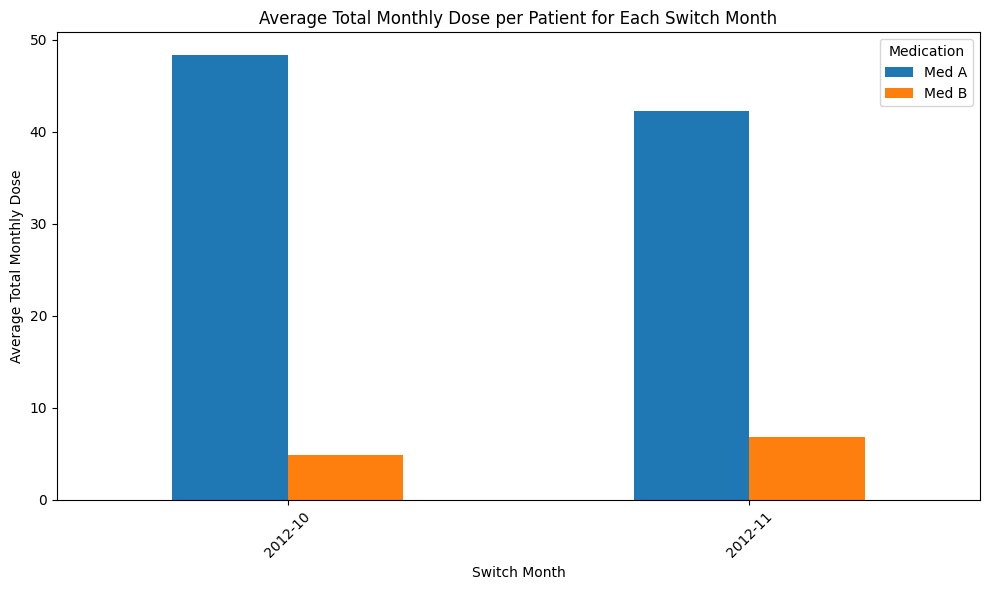

In [54]:
# Identify switch months (September, October, November)
filter_months = [pd.Period('2012-09', freq='M'), pd.Period('2012-10', freq='M'), pd.Period('2012-11', freq='M')]
switch_sep_oct_nov = switch_df[switch_df['Switch Month'].isin(filter_months)]

# Check if 'Admin Date' column exists in admin_df
if 'Admin Date' not in admin_df.columns:
    raise KeyError("The 'Admin Date' column is not found in the admin_df DataFrame.")

# Merge switch data with administration data to get the doses
merged_df = pd.merge(admin_df, switch_sep_oct_nov[['ID', 'Switch Month']], on='ID')

# Ensure 'Admin Date' column is present in the merged DataFrame
if 'Admin Date' not in merged_df.columns:
    raise KeyError("The 'Admin Date' column is not found in the merged_df DataFrame.")

# Calculate total monthly dose per patient for both medications
monthly_dose = merged_df.groupby(['ID', 'Switch Month', 'Med']).resample('M', on='Admin Date')['Units'].sum().reset_index()

# Calculate average total monthly dose per patient for each switch month
avg_monthly_dose = monthly_dose.groupby(['Switch Month', 'Med'])['Units'].mean().unstack()

# Plot the data
plt.figure(figsize=(10, 6))
avg_monthly_dose.plot(kind='bar', ax=plt.gca())
plt.title('Average Total Monthly Dose per Patient for Each Switch Month')
plt.xlabel('Switch Month')
plt.ylabel('Average Total Monthly Dose')
plt.legend(title='Medication')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

8.Second Dose Analysis: For patients switched to Medication B:
What percentage of the second Medication B dose is the same, higher, lower, or zero compared to the first dose?
Lab Value Comparison: For patients that switched from Medication A to B, what was the average LAB B value while on Medication A compared to while on Medication B?

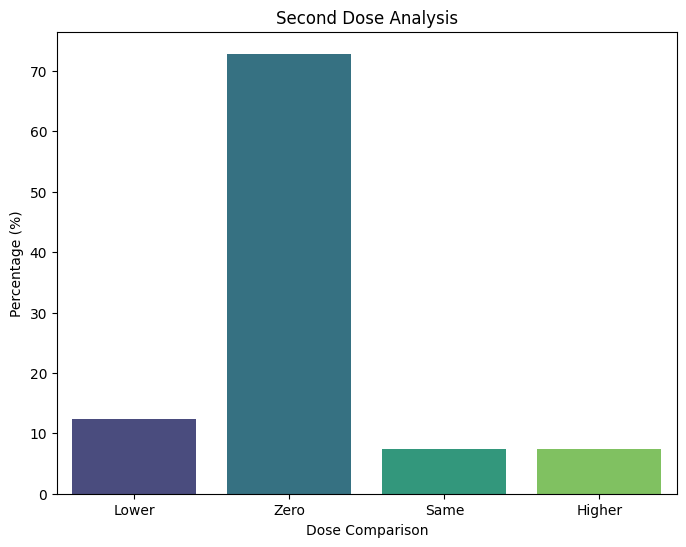

In [58]:
# Identify the second dose for patients who switched to Medication B
med_B_doses = med_B_switch.groupby('ID').apply(lambda x: x.nsmallest(2, 'Admin Date')).reset_index(drop=True)

# Compare first and second dose
dose_comparison = med_B_doses.groupby('ID')['Units'].diff().fillna(0)

# Calculate percentage of second dose being the same, higher, lower, or zero
second_dose_analysis = pd.cut(dose_comparison, bins=[-np.inf, -1, 0, 1, np.inf], labels=['Lower', 'Zero', 'Same', 'Higher']).value_counts(normalize=True) * 100

# Plot the data
plt.figure(figsize=(8, 6))
sns.barplot(x=second_dose_analysis.index, y=second_dose_analysis.values, palette='viridis')
plt.title('Second Dose Analysis')
plt.xlabel('Dose Comparison')
plt.ylabel('Percentage (%)')
plt.show()

### 9. **Lab Value Analysis for Medication A and B:**
To confirm whether Medication B is a suitable replacement for Medication A, we can compare the average lab values for patients while they were on Medication A and Medication B. 

In [59]:
# Merge admin_df and labs_df on 'ID' and 'Admin Date' to combine patient medication and lab data
merged_lab_data = pd.merge(admin_df, labs_df, left_on=['ID', 'Admin Date'], right_on=['ID', 'DRAW_DATE'], how='inner')

# Filter for patients who switched from Medication A to Medication B
lab_switch_data = merged_lab_data[merged_lab_data['ID'].isin(switch_df['ID'])]

# Calculate average LAB_VALUE while on Medication A and while on Medication B
lab_values_A = lab_switch_data[lab_switch_data['Med'] == 'Med A']['LAB_VALUE'].mean()
lab_values_B = lab_switch_data[lab_switch_data['Med'] == 'Med B']['LAB_VALUE'].mean()

print(f"Average LAB_VALUE while on Medication A: {lab_values_A:.2f}")
print(f"Average LAB_VALUE while on Medication B: {lab_values_B:.2f}")

Average LAB_VALUE while on Medication A: 190.00
Average LAB_VALUE while on Medication B: 191.84


### 10. **Efficacy Comparison Based on Lab Values:**
We can now run a statistical test to see if there's a significant difference between the lab values while on Medication A and B.

In [61]:
from scipy.stats import ttest_ind

# Get lab values for patients while on Medication A and B
lab_values_A_data = lab_switch_data[lab_switch_data['Med'] == 'Med A']['LAB_VALUE']
lab_values_B_data = lab_switch_data[lab_switch_data['Med'] == 'Med B']['LAB_VALUE']

# Perform a t-test to check if there is a significant difference between lab values
t_stat, p_value = ttest_ind(lab_values_A_data, lab_values_B_data, nan_policy='omit')

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant difference in lab values between Medication A and B.")
else:
    print("No significant difference in lab values between Medication A and B.")

T-statistic: -0.20
P-value: 0.8395
No significant difference in lab values between Medication A and B.
